In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import os
import random
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import cv2
from sklearn.metrics import confusion_matrix

In [ ]:
# train_dataset_path = '/content/drive/MyDrive/DATASET A/Train'
# test_dataset_path = '/content/drive/MyDrive/DATASET A/Test'
train_dataset_path = '/content/drive/MyDrive/Dataset A2/Train'
test_dataset_path = '/content/drive/MyDrive/Dataset A2/Test'

In [ ]:
input_shape = (150, 120, 3)
batch_size = 32
epochs =25
num_folds = 5

In [ ]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(150, 120))
        img = img_to_array(img) / 255.0  # Normalize the image
        images.append(img)
        labels.append(label)
    return images, labels

In [ ]:
healthy_images, healthy_labels = load_images_from_folder(os.path.join(train_dataset_path, 'Healthy MT'), label=0)
lesion_images, lesion_labels = load_images_from_folder(os.path.join(train_dataset_path, 'Lesion MT'), label=1)

images = healthy_images + lesion_images
labels = healthy_labels + lesion_labels

images = np.array(images)
labels = np.array(labels)

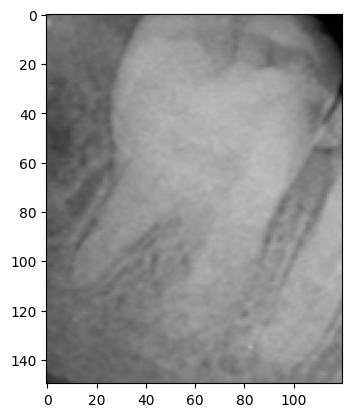

In [ ]:
plt.imshow(images[0])
plt.show()

In [ ]:
folds = [
    {
        "train": [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 69, 70, 71, 72, 74, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 114, 115, 116, 117, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 141, 142, 144, 145, 146, 148, 149, 150, 151, 153, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 171, 172, 174, 175, 179, 180, 181, 182, 183, 184, 186, 187, 188, 190, 191, 193, 195, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 208, 209, 210, 212, 214, 216, 217],
        "val": [9, 15, 16, 18, 25, 30, 45, 55, 66, 67, 73, 75, 79, 93, 96, 100, 108, 109, 113, 118, 119, 136, 139, 140, 143, 147, 152, 154, 155, 162, 170, 173, 176, 177, 178, 185, 189, 192, 194, 203, 207, 211, 213, 215]},
    {
        "train": [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 27, 30, 32, 33, 34, 36, 37, 39, 40, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 59, 61, 62, 63, 64, 66, 67, 70, 71, 72, 73, 74, 75, 77, 79, 80, 81, 83, 85, 87, 88, 89, 90, 91, 92, 93, 94, 96, 98, 99, 100, 102, 103, 105, 106, 107, 108, 109, 110, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 126, 127, 129, 130, 131, 133, 134, 135, 136, 139, 140, 141, 142, 143, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 165, 166, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216, 217],
        "val": [5, 12, 19, 24, 26, 28, 29, 31, 35, 38, 41, 42, 51, 56, 60, 65, 68, 69, 76, 78, 82, 84, 86, 95, 97, 101, 104, 111, 112, 122, 125, 128, 132, 137, 138, 144, 148, 161, 164, 167, 175, 184, 201, 208]},
    {
        "train": [1, 3, 5, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 118, 119, 121, 122, 123, 125, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 210, 211, 213, 214, 215, 217],
        "val": [0, 2, 4, 6, 10, 11, 22, 27, 32, 33, 36, 46, 61, 62, 64, 70, 77, 85, 90, 98, 114, 115, 117, 120, 124, 126, 127, 135, 142, 146, 153, 156, 158, 165, 168, 172, 181, 195, 196, 199, 204, 209, 212, 216]},

    {"train": [0, 1, 2, 4, 5, 6, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 41, 42, 45, 46, 48, 50, 51, 52, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 82, 84, 85, 86, 87, 88, 90, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 132, 135, 136, 137, 138, 139, 140, 142, 143, 144, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 164, 165, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 184, 185, 187, 188, 189, 191, 192, 194, 195, 196, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217],
     "val": [3, 7, 8, 13, 17, 23, 34, 39, 40, 43, 44, 47, 49, 53, 59, 72, 80, 81, 83, 89, 91, 94, 105, 110, 123, 131, 133, 134, 141, 145, 150, 159, 163, 166, 171, 182, 183, 186, 190, 193, 197, 198, 206]},

    {"train": [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 53, 55, 56, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 89, 90, 91, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 152, 153, 154, 155, 156, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 175, 176, 177, 178, 181, 182, 183, 184, 185, 186, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 201, 203, 204, 206, 207, 208, 209, 211, 212, 213, 215, 216],
     "val": [1, 14, 20, 21, 37, 48, 50, 52, 54, 57, 58, 63, 71, 74, 87, 88, 92, 99, 102, 103, 106, 107, 116, 121, 129, 130, 149, 151, 157, 160, 169, 174, 179, 180, 187, 188, 191, 200, 202, 205, 210, 214, 217]}
]

In [ ]:
def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False


    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def augment_data(image):
    image = np.fliplr(image)
    return image

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - accuracy: 0.7136 - loss: 0.5132 - val_accuracy: 0.8636 - val_loss: 0.2770
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.9379 - loss: 0.1678 - val_accuracy: 0.9318 - val_loss: 0.1532
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.9556 - loss: 0.1000 - val_accuracy: 0.9091 - val_loss: 0.1600
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9825 - loss: 0.0840 - val_accuracy: 0.9091 - val_loss: 0.1880
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.9801 - loss: 0.0693 - val_accuracy: 0.9091 - val_loss: 0.1349
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9936 - loss: 0.0300 - val_accuracy: 0.9318 - val_loss: 0.1301
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - accuracy: 0.9962 - loss: 0.0286 - val_accuracy: 0.8864 - val_loss: 0.2251
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9937 - loss: 0.0213 - val_accuracy: 0.8409 - val_loss:

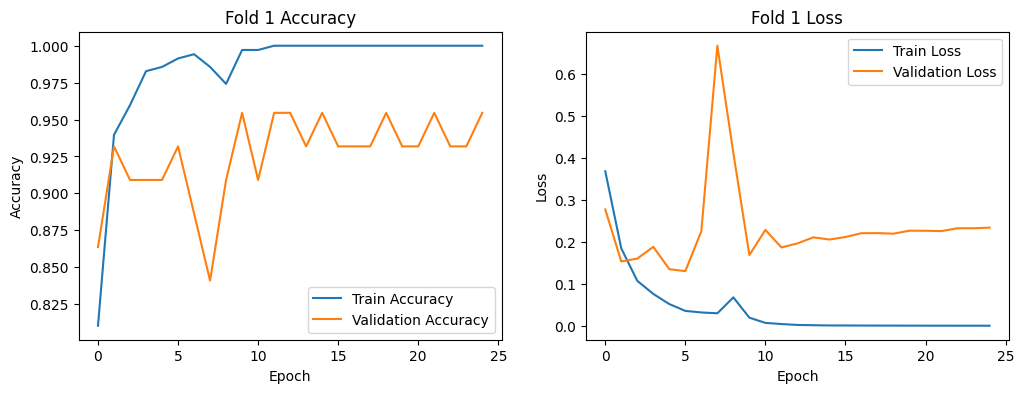

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9593 - loss: 0.1980
Fold 1 - Validation Accuracy: 0.9545454382896423
Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.7613 - loss: 0.4176 - val_accuracy: 0.8864 - val_loss: 0.2468
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - accuracy: 0.9352 - loss: 0.1353 - val_accuracy: 0.9091 - val_loss: 0.2557
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.9622 - loss: 0.0940 - val_accuracy: 0.9091 - val_loss: 0.2089
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.9795 - loss: 0.0560 - val_accuracy: 0.9091 - val_loss: 0.2344
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9945 - loss: 0.0229 - val_accuracy: 0.9318 - val_loss: 0.2754
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 0.8864 - val_loss: 0.3225
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.9318 - val_loss: 0.292

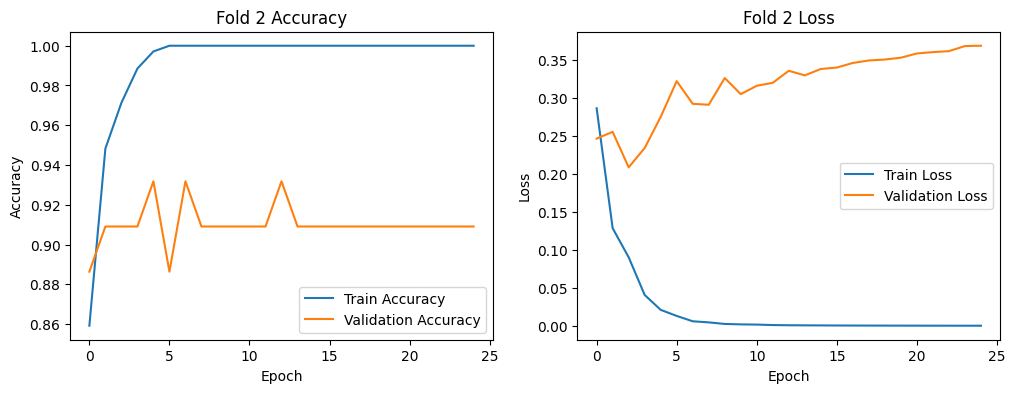

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9081 - loss: 0.4068
Fold 2 - Validation Accuracy: 0.9090909361839294
Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.7030 - loss: 0.4909 - val_accuracy: 0.9545 - val_loss: 0.1174
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.9251 - loss: 0.1963 - val_accuracy: 1.0000 - val_loss: 0.0379
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.9653 - loss: 0.1241 - val_accuracy: 1.0000 - val_loss: 0.0262
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.9545 - loss: 0.1128 - val_accuracy: 1.0000 - val_loss: 0.0442
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9739 - loss: 0.0911 - val_accuracy: 1.0000 - val_loss: 0.0227
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.9864 - loss: 0.0558 - val_accuracy: 1.0000 - val_loss: 0.0125
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9805 - loss: 0.0566 - val_accuracy: 1.0000 - val_loss: 0.0353

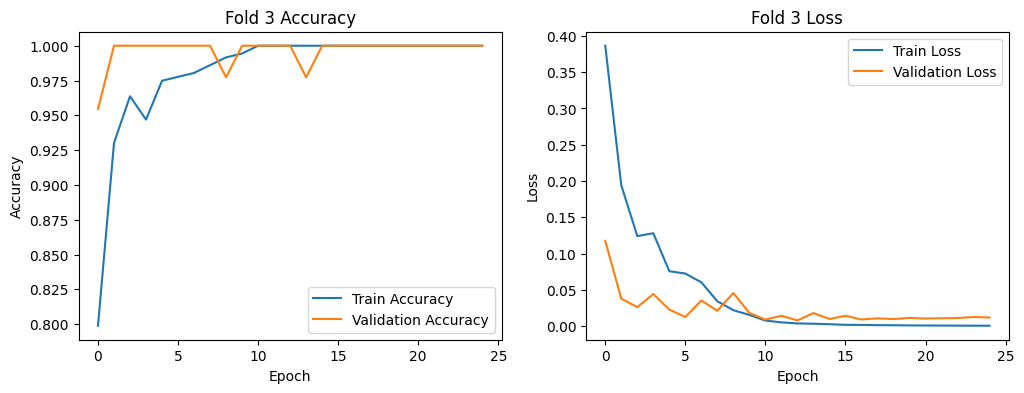

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 1.0000 - loss: 0.0133
Fold 3 - Validation Accuracy: 1.0
Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.6653 - loss: 0.6859 - val_accuracy: 0.9535 - val_loss: 0.1264
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.9293 - loss: 0.2023 - val_accuracy: 0.9302 - val_loss: 0.1099
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.9317 - loss: 0.1672 - val_accuracy: 0.9767 - val_loss: 0.1045
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.9749 - loss: 0.0869 - val_accuracy: 0.9535 - val_loss: 0.1634
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.9905 - loss: 0.0520 - val_accuracy: 0.9535 - val_loss: 0.2163
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.9890 - loss: 0.0480 - val_accuracy: 0.9535 - val_loss: 0.1047
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9888 - loss: 0.0274 - val_accuracy: 0.9535 - val_loss: 0.1089
Epoch 8/25
11/

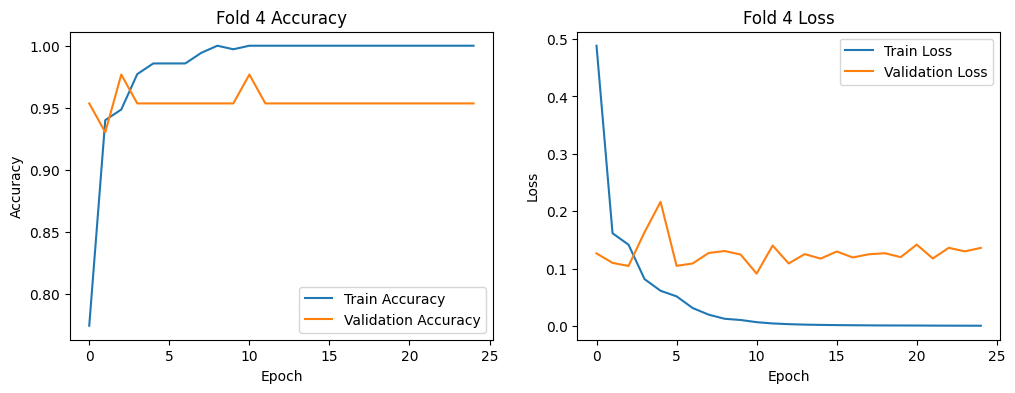

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9482 - loss: 0.1514
Fold 4 - Validation Accuracy: 0.9534883499145508
Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.7382 - loss: 0.5206 - val_accuracy: 0.8605 - val_loss: 0.4097
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9373 - loss: 0.1409 - val_accuracy: 0.8372 - val_loss: 0.5564
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9500 - loss: 0.1298 - val_accuracy: 0.8837 - val_loss: 0.4081
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.9897 - loss: 0.0478 - val_accuracy: 0.9070 - val_loss: 0.3491
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.9860 - loss: 0.0347 - val_accuracy: 0.8837 - val_loss: 0.4855
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.9990 - loss: 0.0137 - val_accuracy: 0.8837 - val_loss: 0.3973
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.8837 - val_loss: 0.467

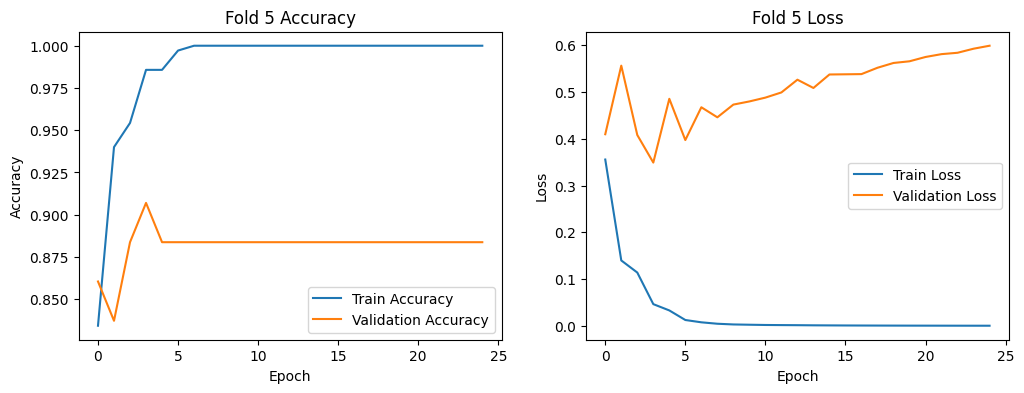

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8912 - loss: 0.4760
Fold 5 - Validation Accuracy: 0.8837209343910217


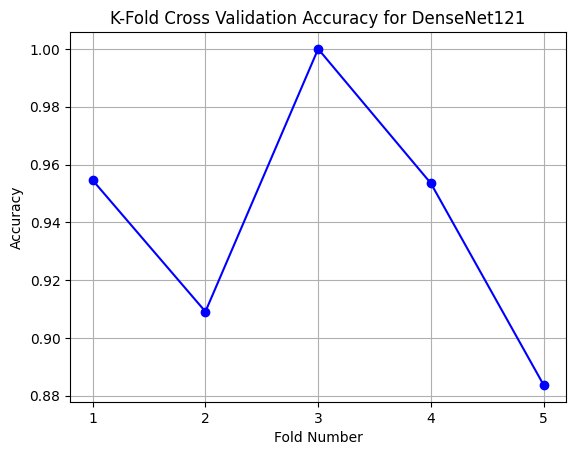


Average Validation Accuracy across 5 folds: 0.9401691317558288


In [ ]:
fold_accuracies3=[]
for fold, fold_data in enumerate(folds):
    train_idx = fold_data['train']
    val_idx = fold_data['val']


    train_images, val_images = images[train_idx], images[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]


    augmented_train_images = np.array(
        [augment_data(img) for img in train_images]
    )


    combined_train_images = np.concatenate((train_images, augmented_train_images))
    combined_train_labels = np.concatenate((train_labels, train_labels))

    val_images = np.array(val_images)

    model3 = create_model()
    history1= model3.fit(
        combined_train_images, combined_train_labels,
        validation_data=(val_images, val_labels),
        epochs=epochs,
        batch_size=batch_size
    )

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Train Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Train Loss')
    plt.plot(history1.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1} Loss')
    plt.legend()
    plt.show()


    val_loss, val_accuracy = model3.evaluate(val_images, val_labels)
    print(f"Fold {fold + 1} - Validation Accuracy: {val_accuracy}")
    fold_accuracies3.append(val_accuracy)

plt.plot(range(1, num_folds + 1), fold_accuracies3, marker='o', linestyle='-', color='b')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('K-Fold Cross Validation Accuracy for DenseNet121')
plt.xticks(range(1, num_folds + 1))
plt.grid(True)
plt.show()

print(f"\nAverage Validation Accuracy across {num_folds} folds: {np.mean(fold_accuracies3)}")

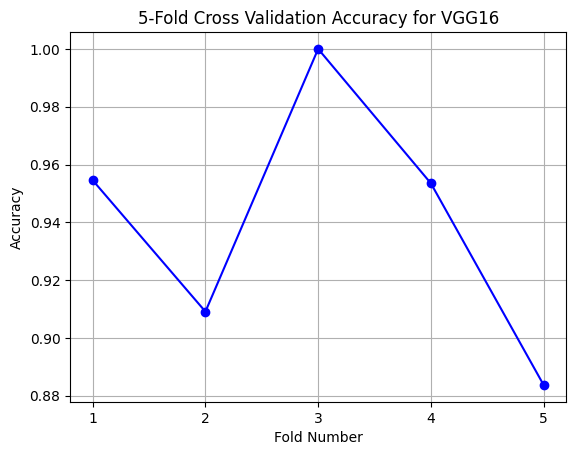

In [ ]:
plt.plot(range(1, 6), fold_accuracies3, marker='o', linestyle='-', color='b')

plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross Validation Accuracy for VGG16')

plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

In [ ]:
print(f"\nAverage Validation Accuracy across {num_folds} folds: {np.mean(fold_accuracies3)}")


Average Validation Accuracy across 5 folds: 0.9401691317558288


In [ ]:
test_images = []
test_labels = []

In [ ]:
for class_name in os.listdir(test_dataset_path):
    class_path = os.path.join(test_dataset_path, class_name)
    label = 0 if class_name == "Healthy MT" else 1

    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)

        img = load_img(img_path, target_size=(150, 120))
        img = img_to_array(img) / 255.0


        test_images.append(img)
        test_labels.append(label)


        flipped_img = np.fliplr(img)
        test_images.append(flipped_img)
        test_labels.append(label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
test_loss3, test_accuracy3 = model3.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy3}")

predictions = model3.predict(test_images)
predicted_classes = (predictions > 0.5).astype(int).flatten()

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, predicted_classes))
print("\nClassification Report:")
print(classification_report(test_labels, predicted_classes, target_names=["Healthy", "Lesion"]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9514 - loss: 0.1083
Test Accuracy: 0.9583333134651184
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step

Confusion Matrix:
[[22  2]
 [ 0 24]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.92      0.96        24
      Lesion       0.92      1.00      0.96        24

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



In [ ]:
model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6144)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │       1,573,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,533,125 (74.51 MB)

 Trainable params: 1,606,145 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 3,212,292 (12.25 MB)

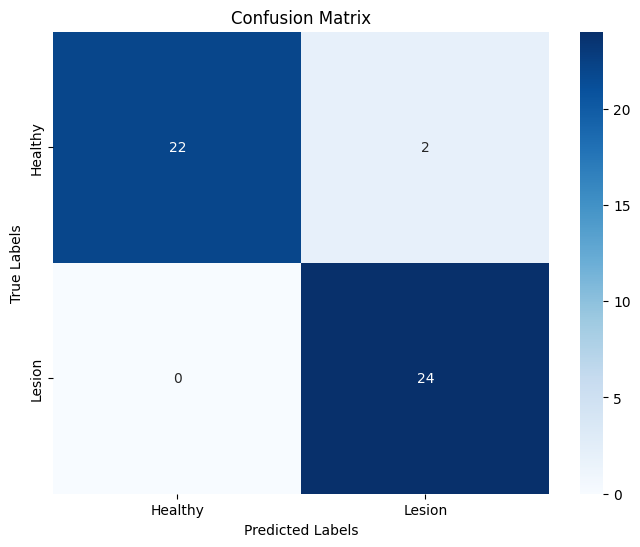

In [ ]:
def plot_confusion_matrix(true_labels, predicted_classes, class_names):
    cm = confusion_matrix(true_labels, predicted_classes)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.show()

plot_confusion_matrix(test_labels, predicted_classes, class_names=["Healthy", "Lesion"])

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step


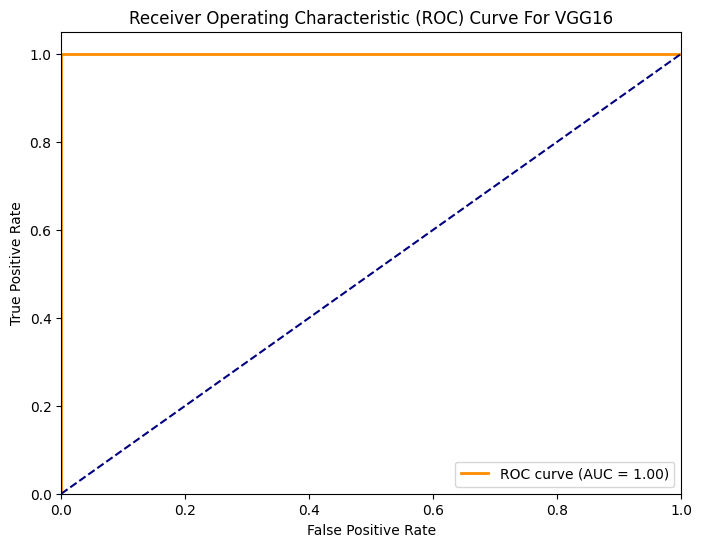

In [ ]:
true_labels = test_labels
predicted_probs = model3.predict(test_images)

def plot_roc_curve(true_labels, predicted_probs):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve For VGG16')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(true_labels, predicted_probs)